<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [1]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!pip install pip install better-profanity --quiet

In [25]:
import pandas as pd
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from better_profanity import profanity
from snorkel.labeling import PandasLFApplier
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher
import numpy as np
nlp = spacy.load("en_core_web_sm")

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 112MB/s] 


We can take a look at the data:

In [4]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'labels' because Snorkel prefers this.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

In [5]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

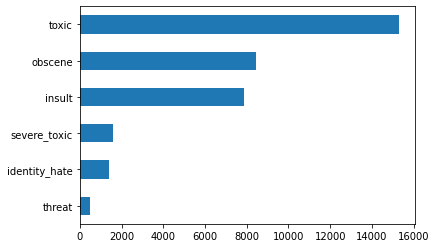

In [6]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Now, let's add them all up together and compare them to the number of clean comments.

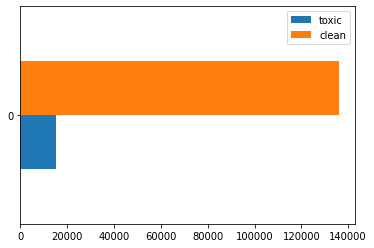

In [7]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced. We will simply reduce the number of clean comments to a number that is comparable to the toxic comments.

In [8]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((30373, 8), (7979, 8))

### Merging All Toxic Comments Together

In [9]:
train_df['labels'] = np.where(train_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
23661,3e83678f022a4ef4,The source linked above contains a lot of vide...,0,0,0,0,0,0,0
149792,6165bf5b7a538d79,"Please, Nobody knows theres a dispute on the C...",0,0,0,0,0,0,0
9555,1954088ba0ef8c80,"""\n\nSentence Structure\nWhy do portions of th...",0,0,0,0,0,0,0
123894,96ae5b376d50b6e9,You can now disregard the WBOP mistake. Sorry ...,0,0,0,0,0,0,0
88307,ec38e8b7bfe689b9,"""\n\n Songwriter credits \n\nI'm a bit suspici...",0,0,0,0,0,0,0


In [10]:
train_df = train_df.drop(LABEL_COLUMNS, axis=1)
train_df

,id,comment_text,labels
138234,e3b8bc8940f2a818,Oaks and Homophobia\nI provided a full citatio...,1
130575,ba7bfe828acbeed3,YOU GUYS ARE STUPID I SHOULDA NEVER JOINED!,1
26183,454bb9ea4d33c682,your dictatorial threats mean nothing to me. ...,1
3396,0927c621f8cb92ff,I am not Jewish and even if I was I am sure yo...,1
130242,b8cf13c4b991f48c,"Yeah, no problem, the International Court of W...",1
...,...,...,...
23661,3e83678f022a4ef4,The source linked above contains a lot of vide...,0
149792,6165bf5b7a538d79,"Please, Nobody knows theres a dispute on the C...",0
9555,1954088ba0ef8c80,"""\n\nSentence Structure\nWhy do portions of th...",0
123894,96ae5b376d50b6e9,You can now disregard the WBOP mistake. Sorry ...,0


## Preparing the Data for Snorkel

In [11]:
train_df = train_df.rename(columns={"comment_text": "text"})
train_df.head()

,id,text,labels
138234,e3b8bc8940f2a818,Oaks and Homophobia\nI provided a full citatio...,1
130575,ba7bfe828acbeed3,YOU GUYS ARE STUPID I SHOULDA NEVER JOINED!,1
26183,454bb9ea4d33c682,your dictatorial threats mean nothing to me. ...,1
3396,0927c621f8cb92ff,I am not Jewish and even if I was I am sure yo...,1
130242,b8cf13c4b991f48c,"Yeah, no problem, the International Court of W...",1


## Writing Labeling Functions (LFs)

For clarity, we define constants to represent the class labels for non-toxic, toxic, and abstaining. These will go into our labeling functions so that the constants feed into the labeling process.

In [12]:
ABSTAIN = -1
NONTOXIC = 0
TOXIC = 1

In [13]:
# Useful for looking at the data and creating the labeling functions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

Let's at a sample of the dataset so that we can come up with labeling functions.

In [14]:
train_df[train_df['labels'] == 1].sample(50, random_state=42)

,id,text,labels
68485,b7320992f8111100,Hey you bitch \n\nDon't undo my edit for no reason. Now piss off,1
142942,fc6bf966bc236863,WHAT IS YOUR PROBLEM!?\n\nWhy can't you just stop blocking me?,1
149565,5de0729d1e6055d9,It's not vandalism you stupid cocksucker! Why are you such a fucking cunt rag!,1
113643,5fb37c45dcae9d88,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS",1
98683,0ff13561d16266e2,"""\n\nfucking cops with no sense of humor. go fuck yourselves, go play """"quidditch"""" you assclowns.""",1
134973,d1e08b909fa030cf,fucking fite me \n\nwhy did you edit my page youre a top class tallywacker i saw your nan in lidl,1
48811,8283eef6b9b86028,"ANYBODY, YOU WERE HARRASSING ME!",1
152601,8fe11e2f7dfea788,""" You forgot to add in your user page """"Being a fucking deaf moron"""" ==\nYOU FUCKING MORONIC PIECE OF SHIT.\n\nYOU CAN""""T EVEN QuOTE CORRECTLY.\n\nHere's what you quoted for the house episode """"airborne""""\n\n """"I'm a board certified expert in infectious disease, whereas she just hands out parking spaces.""""\n\nHere's what he ACTUALLY Said\n\n """"I'm a board certified specialist in infectious disease, she assigns parking spaces.""""\n\nMan, it's fucking morons like you that makes wiki so shitty. Mid 40 yr old piece of shit. stop bragging about reading x number books, or working at the largest company, you're clearly falling apart biologically and if you can't even hear correctly, how the fuck are you going to contribute to wiki?\n\nThanks asshole for fill wikipedia 

In [15]:
# Showing the most common words to make the labeling function creation process quicker
# This is where we can come up with a custom keyword list

pd.Series(' '.join(train_df[train_df['labels'] == 1].sample(50, random_state=42).text).split()).value_counts()[:50]

BOOBS,     362
and         91
a           83
you         81
to          81
the         69
I           66
of          59
me          39
is          37
i           34
my          34
was         32
that        31
in          31
your        29
he          29
for         28
him         28
or          24
what        23
this        22
as          21
just        21
with        20
had         19
then        19
on          18
are         18
not         18
at          17
And         17
about       17
it          17
Deepak      16
"           16
why         16
who         15
were        15
up          14
have        14
fucking     13
so          13
an          13
edits       13
got         12
get         12
be          12
no          12
his         12
dtype: int64

### Labeling Functions

In [16]:
@nlp_labeling_function()
def contains_work_of_art(x):
    """If comment contains titles of books, songs, etc., label non-toxic, else abstain"""
    if any([ent.label_ == "WORK_OF_ART" for ent in x.doc.ents]):
        return NONTOXIC
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def contains_entity(x):
    """If comment contains least 3 mentions of an entity, label non-toxic, else abstain"""
    if len([ent.label_ in ["PERSON", "GPE", "LOC", "ORG", "LAW", "LANGUAGE"] for ent in x.doc.ents])>2:
        return NONTOXIC
    else:
        return ABSTAIN

In [17]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    """If comment has a polarity score between +0.9 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    """If comment has a subjectivity score between +0.7 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.subjectivity >= 0.7 else ABSTAIN

In [18]:
@labeling_function()
def contains_profanity(x):
    """
    If comment contains profanity label toxic, else abstain. 
    Profanity determined using this library - https://github.com/snguyenthanh/better_profanity
    """
    return TOXIC if profanity.contains_profanity(x.text) else ABSTAIN

In [19]:
@nlp_labeling_function()
def contains_pleaseread(x):
    """
    Will match commonly occuring phrases like - 
    Please read this
    Please read the
    Please read
    """
    matcher = Matcher(nlp.vocab)
    pattern = [{"LEMMA": "please"},
               {"LEMMA": "read"},
               {"LEMMA": "the", "OP": "?"},
               {"LEMMA": "this", "OP": "?"}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_stopvandalizing(x):
    """
    Will match commonly occuring phrases like - 
    stop vandalizing
    do not vandalize
    don't vandalize
    """
    matcher = Matcher(nlp.vocab)
    pattern1 = [{"LEMMA": "do"},
                {"LEMMA": "not"},
                {"LEMMA": "vandalize"}]
    pattern2 = [{"LEMMA": "stop"}, 
                {"LEMMA": "vandalize"}]
    matcher.add("p1", None, pattern1)
    matcher.add("p2", None, pattern2)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_harassme(x):
    """
    Will match commonly occuring phrases like - 
    harass me
    harassed me
    harassing me
    """
    matcher = Matcher(nlp.vocab)
    pattern = [{"LOWER": "harass"}, 
               {"LOWER": "me"}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_willreport(x):
    """Will match commonly observed phrases like - 
    report you
    reported you
    reporting you
    reported your
    """
    matcher = Matcher(nlp.vocab)
    pattern = [{"LEMMA": "report"}, 
               {"LEMMA": "you"}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [20]:
@nlp_labeling_function()
def contains_email(x):
    """If comment contains email address, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_EMAIL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_url(x):
    """If comment contains url, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_URL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [21]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=TOXIC):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

with open('badwords.txt') as f:
    toxic_stopwords = f.readlines()

toxic_stopwords = [x.strip() for x in toxic_stopwords] # len = 458
"""Comments mentioning at least one of Google's Toxic Stopwords 
https://code.google.com/archive/p/badwordslist/downloads are likely toxic"""
keyword_toxic_stopwords = make_keyword_lf(keywords=toxic_stopwords)

keyword_please = make_keyword_lf(keywords=["please", "plz", "pls", "pl"], label=NONTOXIC)

keyword_thanks = make_keyword_lf(keywords=["thanks", "thank you", "thx", "tx"], label=NONTOXIC)

In [22]:
@labeling_function()
def capslock(x):
    """If comment is written in all caps, label toxic, else abstain"""
    return TOXIC if x.text == x.text.upper() else ABSTAIN

In [23]:
lfs = [
      contains_work_of_art,
      contains_entity,
      textblob_polarity,
      textblob_subjectivity,
      contains_profanity,
      contains_pleaseread,
      contains_stopvandalizing,
      contains_harassme,
      contains_willreport,
      contains_email,
      contains_url,
      keyword_toxic_stopwords,
      keyword_please,
      keyword_thanks,
      capslock
]

## Applying the Labeling Functions

In [ ]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)
# L_val = applier.apply(df=val_df)

Streaming output truncated to the last 5000 lines.
 47%|████▋     | 14306/30373 [1:08:29<1:00:45,  4.41it/s]

In [ ]:
import pickle

with open('L_train_1k_keyword_lookup.pkl','wb') as f:
  pickle.dump(L_train, f)
with open('L_train_1k_keyword_lookup.pkl','rb') as f:
  L_train = pickle.load(f)
  print(x.shape)